In [4]:
import sys; sys.path.append("..")
from epi_model import *

In [8]:
xx = temporalNetwork.load('high school')

# determine position

In [10]:
G = nx.Graph()
wts = Counter([(u,v) for t,u,v in xx.edgelist])
G.add_weighted_edges_from([(u,v, wts[(u,v)]) for (u,v) in wts])
pos = nx.spring_layout(G)

# draw slices

In [ ]:
start = 1385982020

In [ ]:
days = [
    start,
    start+50000,
    start+150000,
    start+200000,
    start+300000,
    start+400000
]

In [ ]:
plt.hist([x[0]-start for x in xx], bins=100);

In [ ]:
day_cs = {}
for DAY in range(5):
    day_begin = days[DAY]
    day_end = days[DAY+1]
    day_cs[DAY] = Counter([(u,v) for t,u,v in xx if day_begin <= t <= day_end])

In [ ]:
from itertools import chain
all_keys = set(chain.from_iterable( [x.keys() for x in day_cs.values()] ))
all_keys = list(all_keys)

In [ ]:
for k in all_keys[:100]:
    plt.plot(range(5), [day_cs[i][k] for i in range(5) ])
plt.ylim(0,50)

In [ ]:
list(pos.items())[:5]

In [ ]:
xs = np.array([x[0] for x in pos.values()])
ys = np.array([x[1] for x in pos.values()])
X_LIM = (xs.min(),xs.max())
Y_LIM = (ys.min(),ys.max())

In [ ]:
# make time-aggregated network

plt.figure(figsize=(10*3,10*3))

for DAY in range(5):
    
    plt.subplot(3,3,DAY+1)
    
    day_begin = days[DAY]
    day_end = days[DAY+1]

    G = nx.Graph()
    wts = Counter([(u,v) for t,u,v in xx if day_begin <= t <= day_end])
    G.add_weighted_edges_from([(u,v, wts[(u,v)]) for (u,v) in wts])
    
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    weights = np.array(weights)
    weights = weights / np.max(weights)

    weights = np.log(weights)
    weights = weights + -np.min(weights)
    weights = weights / weights.max()

    arcs = nx.draw_networkx_edges(G, pos, edgelist=edges, node_size=1, edge_color=weights, width=1, edge_cmap=plt.cm.Blues)
    #node_color='b', , 
    arcs.set_color([(0,0,0,w) for w in weights])
    nx.draw_networkx_nodes(G, pos, node_size=1)
    plt.xlim(*X_LIM)
    plt.ylim(*Y_LIM)

# make a nice animation

In [ ]:
start = 1385982020

In [ ]:
days = [
    start,
    start+50000,
    start+150000,
    start+200000,
    start+300000,
    start+400000
]

In [ ]:
window = 15*60
FPS = 20

# one hour every two seconds
step = 60*60 / (FPS*2)

In [ ]:
# create the folder
# delete the files
fold = Path("net_anim_more")
fold.mkdir(exist_ok=True)
for f in fold.glob("*"):
    if f.is_dir():
        continue
    f.unlink()

In [ ]:
# determine X and Y LIM


G = nx.Graph()
wts = Counter([(u,v) for t,u,v in xx])
G.add_weighted_edges_from([(u,v, wts[(u,v)]) for (u,v) in wts])

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

arcs = nx.draw_networkx_edges(G, pos, edgelist=edges, node_size=1, width=1)
#node_color='b', , 
#arcs.set_color([(0,0,0,w) for w in weights])
nx.draw_networkx_nodes(G, pos, node_size=1)

X_LIM = plt.xlim()
Y_LIM = plt.ylim()

In [ ]:
xxdf = pd.DataFrame.from_records( xx )

In [ ]:
xxdf.loc[ xxdf[0] >= 1386345580].shape

In [ ]:
def generate(i):
    if i % 100 == 0:
        print("Frame %s" % i)
        pass
    
    old_outf = fold.joinpath('%03.0f.png' % i)
    new_outf = fold.joinpath('%05.0f.png' % i)
    if new_outf.exists():
        return
    
    if old_outf.exists():
        #print("Renaming %s to %s" % (old_outf,new_outf))
        old_outf.rename(new_outf)
        return
    
    day_begin = start + i*step
    day_end = start + i*step + window
    
    if xxdf.loc[ (day_begin <= xxdf[0])&(xxdf[0] <= day_end) ].shape[0] == 0:
        #print("skipping %s" % i)
        return
    
    G = nx.Graph()
    wts = Counter([(u,v) for t,u,v in xx if day_begin <= t <= day_end])
    
    fig, ax = plt.subplots(figsize=(15,15))
    #print(day_begin, day_end)

    G.add_weighted_edges_from([(u,v, wts[(u,v)]) for (u,v) in wts])

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    weights = np.array(weights)
    weights = weights / np.max(weights)

    weights = np.log(weights)
    weights = weights + -np.min(weights)
    weights = weights / weights.max()

    arcs = nx.draw_networkx_edges(G, pos, edgelist=edges, node_size=1, edge_color=weights, width=1, edge_cmap=plt.cm.Blues)
    #node_color='b', , 
    arcs.set_color([(0,0,0,w) for w in weights])
    
    nx.draw_networkx_nodes(G, pos, node_size=1, node_color='white')

    for ii,c in enumerate(classes):
        shift_v = np.array( [
            np.cos((ii/len(classes)) * 2 * np.pi),
            np.sin((ii/len(classes)) * 2 * np.pi),
        ] )*C_DIST

        # draw the circles
        circ = plt.Circle(shift_v, 1, color='b', alpha=0.1)
        plt.text( shift_v[0], shift_v[1]+1.1, c, horizontalalignment='center' )
        ax.add_patch(circ)
        
    
    sdt = dt.datetime.fromtimestamp(day_begin) + dt.timedelta(hours=6)
    edt = dt.datetime.fromtimestamp(day_end) + dt.timedelta(hours=6)
    
    txRect = plt.Rectangle([-1.25,-0.25], 2.5, 1, color='white', ec='black', alpha=1)
    ax.add_patch(txRect)
        
    tx = "%s\n%s - %s" % (
        sdt.strftime("%a, %D"),
        sdt.strftime("%I:%M %p"),
        edt.strftime("%I:%M %p")
    )
    plt.text( 0,0, tx, horizontalalignment='center', fontsize=20 )
        
    
    plt.xlim(*X_LIM)
    plt.ylim(*Y_LIM)
    
    
    plt.savefig( outf )
    plt.close()

In [ ]:
times = np.array([x[0] for x in xx])

In [ ]:
num_steps = int((times.max() - times.min() - window) // step)

In [ ]:
num_steps

In [ ]:
#for i in range(24):
for i in range(num_steps):
    generate(i);

In [ ]:
outf

In [ ]:
len(list(fold.glob("*.png"))) / FPS

In [ ]:
# they aint in a row!
for i,f in enumerate(sorted(fold.glob("*.png"))):
    #print(f.name, "%05d.png"%i)
    #continue
    f.rename(fold.joinpath("%05d.png"%i))

In [ ]:
# make movie
outf = fold.joinpath("full_video.mp4")
if outf.exists():
    outf.unlink()
    
f_pattern = str(fold.joinpath("%05d.png"))
#!ffmpeg -r {FPS} -f image2 -s 1080x1080 -i {f_pattern} -vcodec libx264 -t 83.45 -crf 25  -pix_fmt yuv420p {outf}
!ffmpeg -framerate {FPS} -i {f_pattern} -c:v libx264 -r 30 {outf}

In [ ]:
if False:
    # make gif -- not practical for really smooth animation...
    import imageio
    with imageio.get_writer(fold.joinpath('00_.gif'), mode='I', fps=FPS) as writer:
        for filename in sorted(fold.glob("*.png")):
            image = imageio.imread(str(filename))
            writer.append_data(image)

# some trash -- wanted to make the temporally think edges

In [ ]:
# yeah there's no way I can do it with networkx
# I need to learn to draw these myself, probably using...
def shift(x,y,i):
    delt=0.01
    v = y - x
    print(v)
    vt = [v[1], -v[0]]
    vt = np.array(vt)
    
    vt = vt/vt.norm()
    return np.array([x,y]) + vt * 0.01 * i

In [ ]:
# make time-aggregated network

plt.figure(figsize=(15,15))

for DAY in range(5):
    
    day_begin = days[DAY]
    day_end = days[DAY+1]
    
    pos_shifted = {
        k:shift(x,y,DAY)
        for k,(x,y) in pos.items()
    }

    G = nx.Graph()
    wts = Counter([(u,v) for t,u,v in xx if day_begin <= t <= day_end])
    G.add_weighted_edges_from([(u,v, wts[(u,v)]) for (u,v) in wts])
    
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    weights = np.array(weights)
    weights = weights / np.max(weights)

    weights = np.log(weights)
    weights = weights + -np.min(weights)
    weights = weights / weights.max()

    arcs = nx.draw_networkx_edges(G, pos_shifted, edgelist=edges, node_size=1, edge_color=weights, width=1, edge_cmap=plt.cm.Blues)
    #node_color='b', , 
    arcs.set_color([(0,0,0,w/5) for w in weights])
    nx.draw_networkx_nodes(G, pos, node_size=1, node_color='white')

    for i,c in enumerate(classes):
        shift_v = np.array( [
            np.cos((i/len(classes)) * 2 * np.pi),
            np.sin((i/len(classes)) * 2 * np.pi),
        ] )*C_DIST

        # draw the circles
        circ = plt.Circle(shift_v, 1, color='b', alpha=0.1)
        plt.text( shift_v[0], shift_v[1]+1.1, c, horizontalalignment='center' )
        ax.add_patch(circ)
        
    plt.xlim(*X_LIM)
    plt.ylim(*Y_LIM)

In [ ]:
nbs = nx.neighbors(G, n[2])
subg = nx.subgraph(G, nbs)
nx.draw_circular( subg )

# working example in jupyter

In [84]:
a = temporalNetwork.load('high school')

In [63]:
a = a.range(1,2)

In [85]:
ccc = a.node_attr['class']

classes = {
    c: [k for k,v in ccc.items() if v==c]
    for c in set(ccc.values())
}

In [86]:
css = a.node_attr['class']

In [87]:
nds = sorted(a.node_attr['class'])

In [88]:
class_map = a.node_attr['class']

In [143]:
C_DIST = 2

In [144]:
pos = {}

for i,c in enumerate(classes):
    gnodes = [ k for k,v in class_map.items() if v==c ]
    
    G = nx.Graph()
    wts = Counter([(u,v) for t,u,v in a.edgelist if (u in gnodes and v in gnodes)])
    G.add_nodes_from(gnodes)
    G.add_weighted_edges_from([(u,v, wts[(u,v)]) for (u,v) in wts])
    pos_class = nx.spring_layout(G)
    
    #shift_v = np.array( [
    #    np.cos((i/len(classes)) * 2 * np.pi),
    #    np.sin((i/len(classes)) * 2 * np.pi),
    #] ) * C_DIST
    shift_v = np.array([C_DIST,0]) * i

    for k,v in pos_class.items():
        pos[k] = v + shift_v

In [145]:
len(nds)

327

In [146]:
len(pos)

327

In [147]:
len([x for x in a.edgelist if css[x[1]]==css[x[2]]])

350538

In [148]:
G = nx.DiGraph()
wts = Counter([(u,v) for t,u,v in a.edgelist])
G.add_weighted_edges_from([(u,v, wts[(u,v)]) for (u,v) in wts])

In [149]:
CUTOFF = 15 # 15 segments * 20s = 5 minutes

In [150]:
len(edges)

2516

In [151]:
from matplotlib.patches import ConnectionStyle

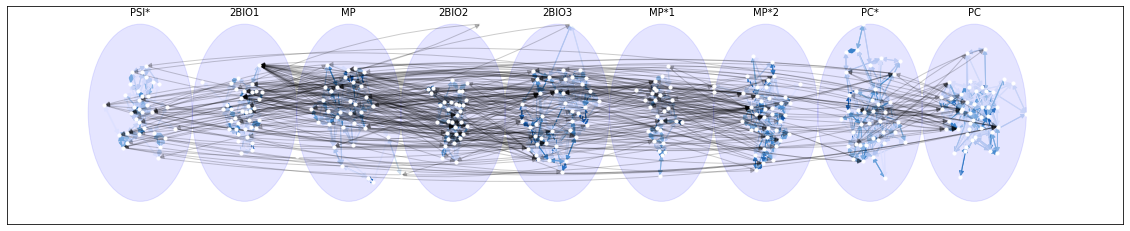

In [153]:
fig,ax = plt.subplots(figsize=(20,4))

edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(G,'weight').items() if css[e1]==css[e2] and w>=CUTOFF])
edges2, weights2 = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(G,'weight').items() if css[e1]!=css[e2] and w>=CUTOFF])

weights = np.array(weights)
weights = weights / np.max(weights)

weights = np.log(weights)
weights = weights + -np.min(weights)
weights = weights / weights.max()

#node_color='b', , 
arcs = nx.draw_networkx_edges(G, pos, edgelist=edges, node_size=1, edge_color=weights, width=1, edge_cmap=plt.cm.Blues)
#arcs.set_color([(0,0,0,w/3) for w in weights])
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='white')

for i,c in enumerate(classes):
    shift_v = np.array( [
        C_DIST,
        0,
    ] )*i
    
    # draw the circles
    circ = plt.Circle(shift_v, 1, color='b', alpha=0.1)
    plt.text( shift_v[0], shift_v[1]+1.1, c, horizontalalignment='center' )
    ax.add_patch(circ)

arcs2 = nx.draw_networkx_edges(G, pos, edgelist=edges2, node_size=1, width=1, alpha=0.2,
                               #connectionstyle="arc3, rad=0.2"  # <-- THIS IS IT
                               connectionstyle=ConnectionStyle.Arc3(rad=0.1)
                               #connectionstyle="angle3,angleA=45,angleB=-45",
                               #connectionstyle="bar,fraction=0.3",
                              )
#nx.draw_networkx_nodes(G, pos, node_size=100, nodelist=[i for i in G.nodes if a.stateT(i,T)=='inf'], node_color='yellow', edgecolors='black')
    
plt.savefig('classes_diagram_limited.png')